In [6]:
import rust as rs
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

In [2]:
y = rs.shooter(0, 0, 1, 0.5, np.linspace(0, 10, 1000), 1e-3, 2, True, True)
print(y)

[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.

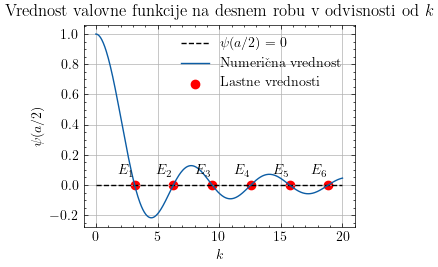

In [7]:


# from bvp import fd, shoot, rku4
# from diffeq import rku4
import scipy.optimize as opt
import scipy.interpolate as interp

# def schrodinger(x, k):
#     return np.array([x[1], -k**2 * x[0]])

n = 500
k_s = np.linspace(0, 20, n)
t = np.linspace(0, 1, n)

solutions = np.ones_like(k_s)
for i, k in enumerate(k_s):
    # f = lambda x, t: schrodinger(x, k)
    x = rs.sch_rk4(k**2, [0., 1.], t)
    solutions[i] = x[-1][0]

zero_crossings = np.where(np.diff(np.sign(solutions)))[0]
k_zeros = np.array([opt.brentq(lambda k: interp.interp1d(k_s, solutions)(k), k_s[i], k_s[i+1]) for i in zero_crossings])


plt.hlines(0, 0, 20, linestyles='dashed', colors='black', label='$\\psi(a/2) = 0$')
plt.plot(k_s, solutions, label='Numerična vrednost')

plt.grid()
plt.xlabel('$k$')
plt.ylabel('$\\psi(a/2)$')
plt.title('Vrednost valovne funkcije na desnem robu v odvisnosti od $k$')
plt.scatter(k_zeros, np.zeros_like(k_zeros), color='red', label='Lastne vrednosti')
for i, k in enumerate(k_zeros):
    label = '$E_{' + str(i+1) + '}$'
    plt.text(k - 0.1, 0.05, label,  verticalalignment='bottom', horizontalalignment='right')

plt.legend()
plt.show()




 0: z =    1.000e0, error =  -2.520e-6
 1: z =    1.000e0, error =  -1.260e-6


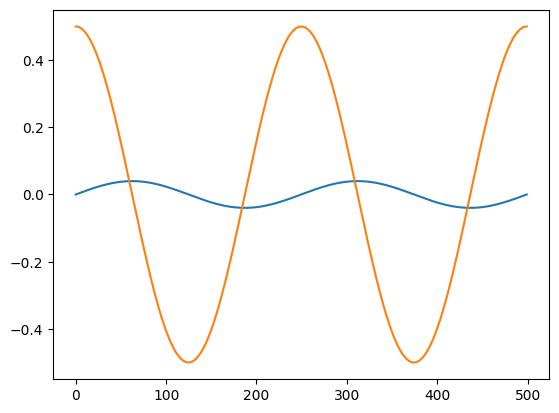

[1.808186874054169e-17, 1.0918688392138746e-19]
 0: z =    1.000e0, error =  -2.331e-2
 1: z =    1.000e0, error =  -1.165e-2
 2: z =   5.000e-1, error = -1.294e-18


In [5]:
plt.plot(rs.shooter(0, 0, 1, 0.5, t, 1e-3, k_zeros[3]**2, False, False))
plt.show()
print(max(rs.shooter(0, 0, 1, 0.5, t, 1e-3, k_zeros[2], False, False)))